<span style="font-size: 14pt">MIPT, Advanced ML, Autumn 2017</span>

<span style="font-size: 16pt"> HW #2: ARMA, ARIMA

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<h1 align="center">Organization Info</h1> 

**Дополнительный материал для выполнения дз**:
- Магнус Я.Р., Катышев П.К., Пересецкий А.А. Эконометрика. Начальный курс., глава 11
- Лукишн Ю.П. Адаптивные методы краткосрочного прогнозирования временных рядов. Финансы и статистика. 2003, главы 1,4,5,7.

**Оформление дз**: 
- Присылайте выполненное задание на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2017_Aut_fall <номер_группы> <фамилия>``, к примеру -- ``ML2017_Aut_fall 401 ivanov``
- Выполненное дз сохраните в файл ``<фамилия>_<группа>_task<номер>.ipnb``, к примеру -- ``ivanov_401_task1.ipnb``

**Вопросы**:
- Присылайте вопросы на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2017_Aut_fall Question <Содержание вопроса>``

--------
- **PS1**: Мы используем автоматические фильтры, и просто не найдем ваше дз, если вы не аккуратно его подпишите.
- **PS2**: Напоминаем, что дедлайны жесткие, письма пришедшие после автоматически удаляются =( чтобы соблазна не было 

<h1 align="center">Check Questions (20%)</h1> 

Выложили ответы поэтому как я понял баллов мне не поставят за это

<h1 align="center"> Practice</h1>

<h2 align="center">  1. Download data for following data sets (10%)</h2>
* 1) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">TS_dep36.csv</span> (105 TS of goods sales in the shop #36 of one real Retail Net, each TS correspond to an item in this shop )
* 2) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">TS_dep42.csv</span> (105 TS of goods sales in shop #42 of one real Retail Net, each TS correspond to an item in this shop)
* 3) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">TS_dep6.csv </span>(110 TS of goods sales in shop #6 of one real Retail Net, each TS correspond to an item in this shop)

All data you can find by <a href='https://1drv.ms/f/s!AqGgzb5T4tvShb8iJuzFHOeXR11wOg'>link</a> 

* For each data set: 
      - 1) learn it's structure in csv-file and read it into Pandas data frame (be careful with parsing data)
      - 2) plot each time series
      - 3) answer the questions: is there seasonlaity, trend, changes in level in TS? If there is seasonality then define period of seasonality. 

In [47]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import gridspec
import math
import pandas.tseries.offsets as ofs
import statsmodels.api as sm
from statsmodels.tsa import stattools
from scipy.stats import ttest_1samp, shapiro, probplot
import warnings
from IPython.display import Image
from utils import qualityMACAPE, qualityRMSE
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline

In [48]:
dep6 = pd.read_csv('TS_dep6.csv', sep=';', decimal='.', parse_dates=True, index_col=0)
dep36 = pd.read_csv('TS_dep36.csv', sep=';', decimal=',', parse_dates=True, index_col=0)
dep42 = pd.read_csv('TS_dep42.csv', sep=';', decimal=',', parse_dates=True, index_col=0)

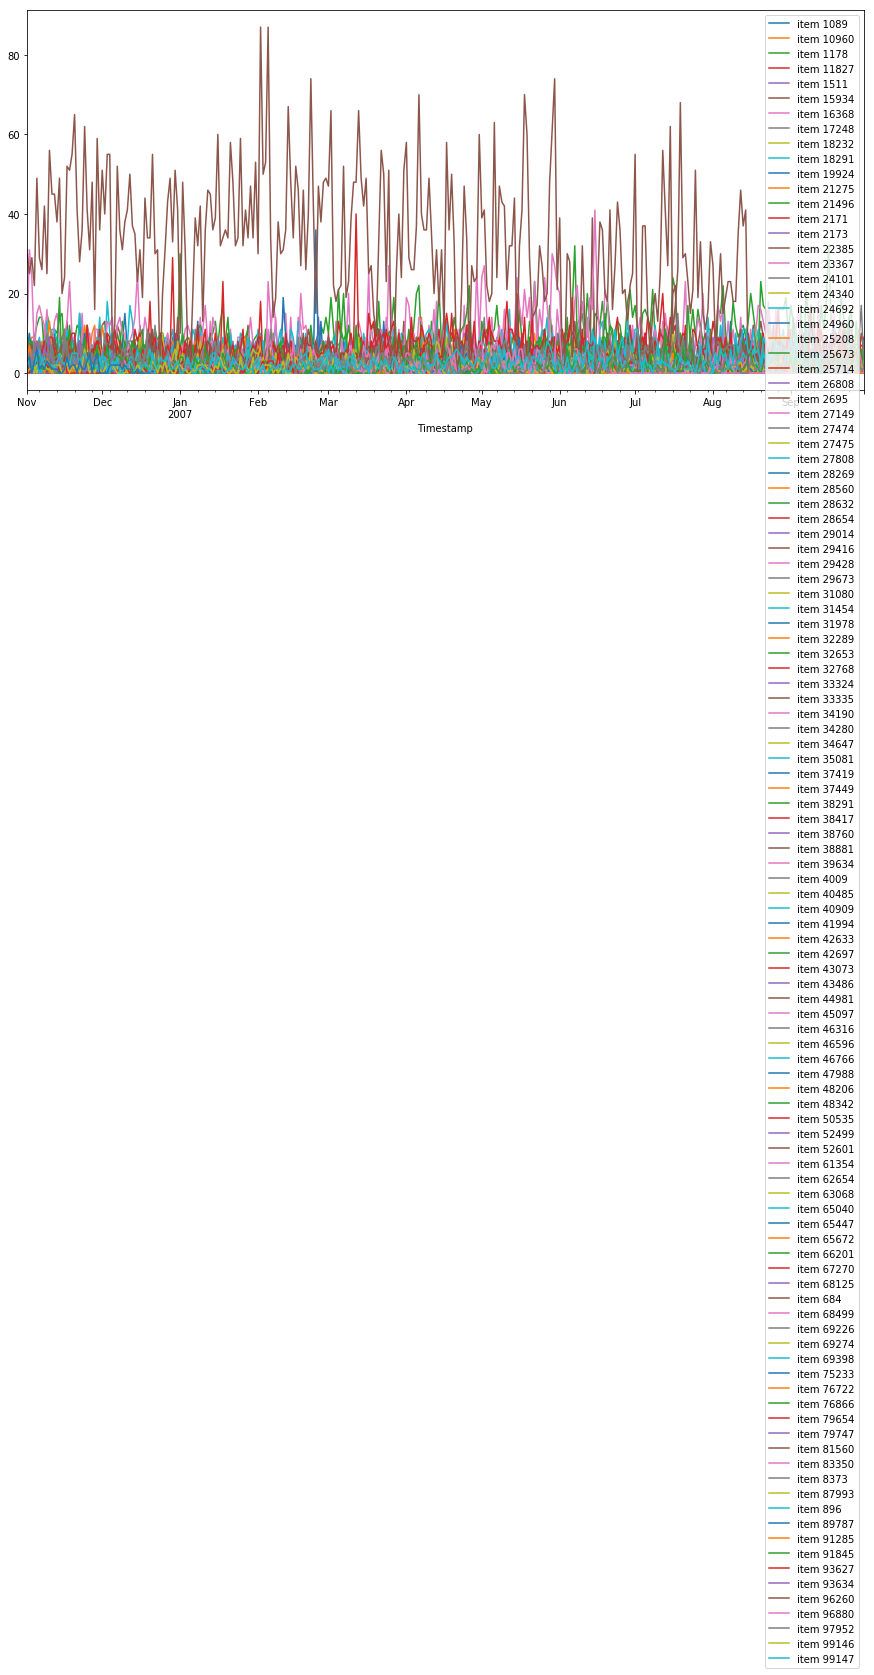

In [65]:
dep6.plot(figsize=(15, 7))

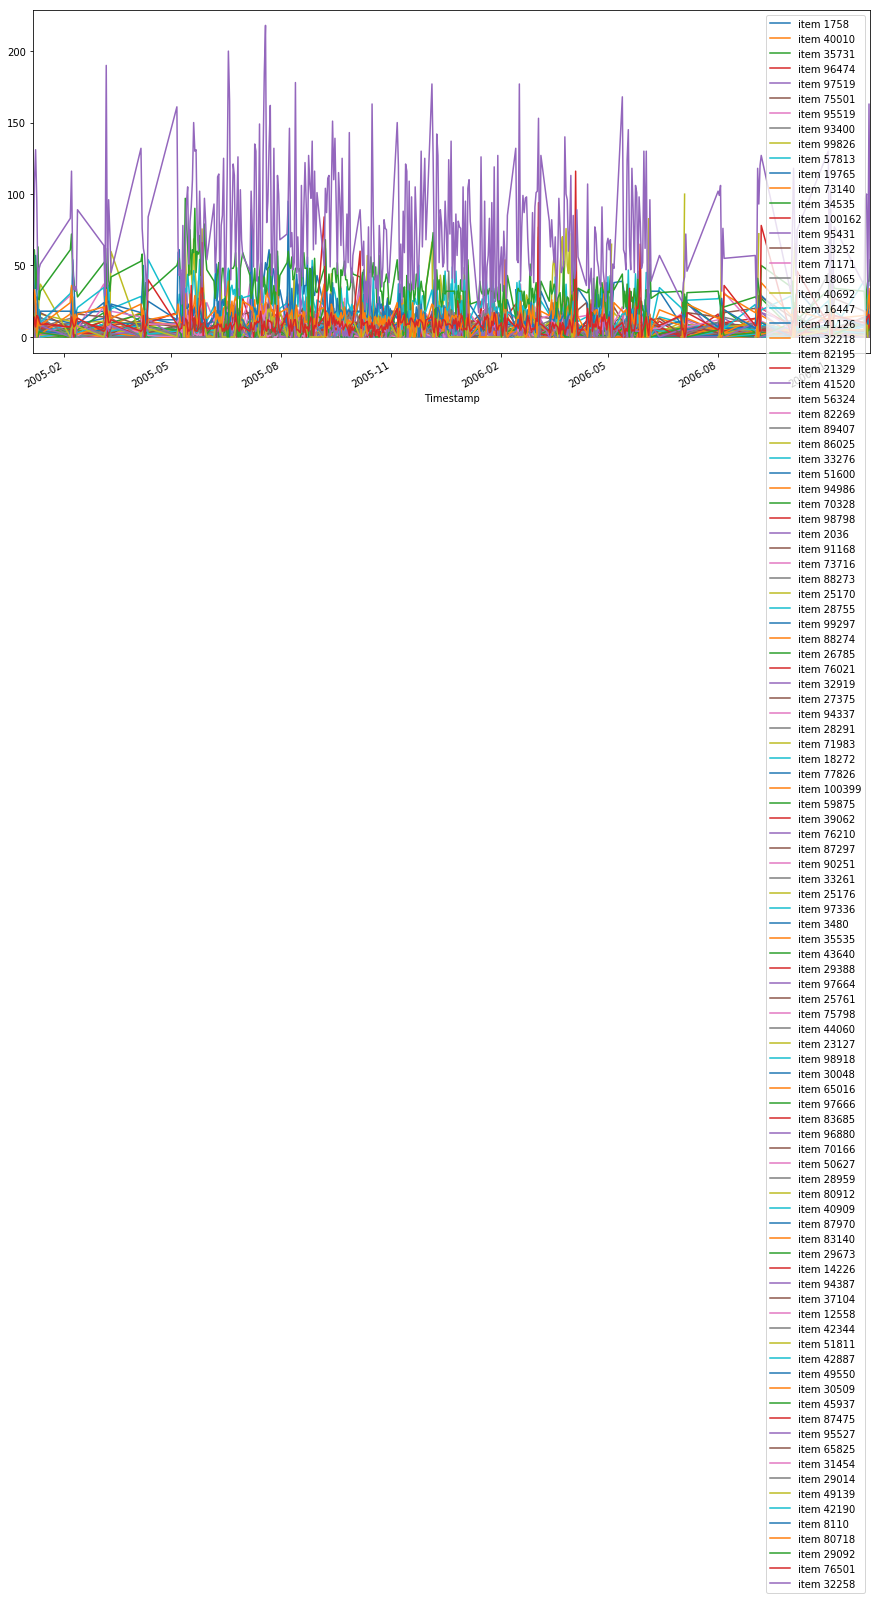

In [66]:
dep36.plot(figsize=(15, 7))

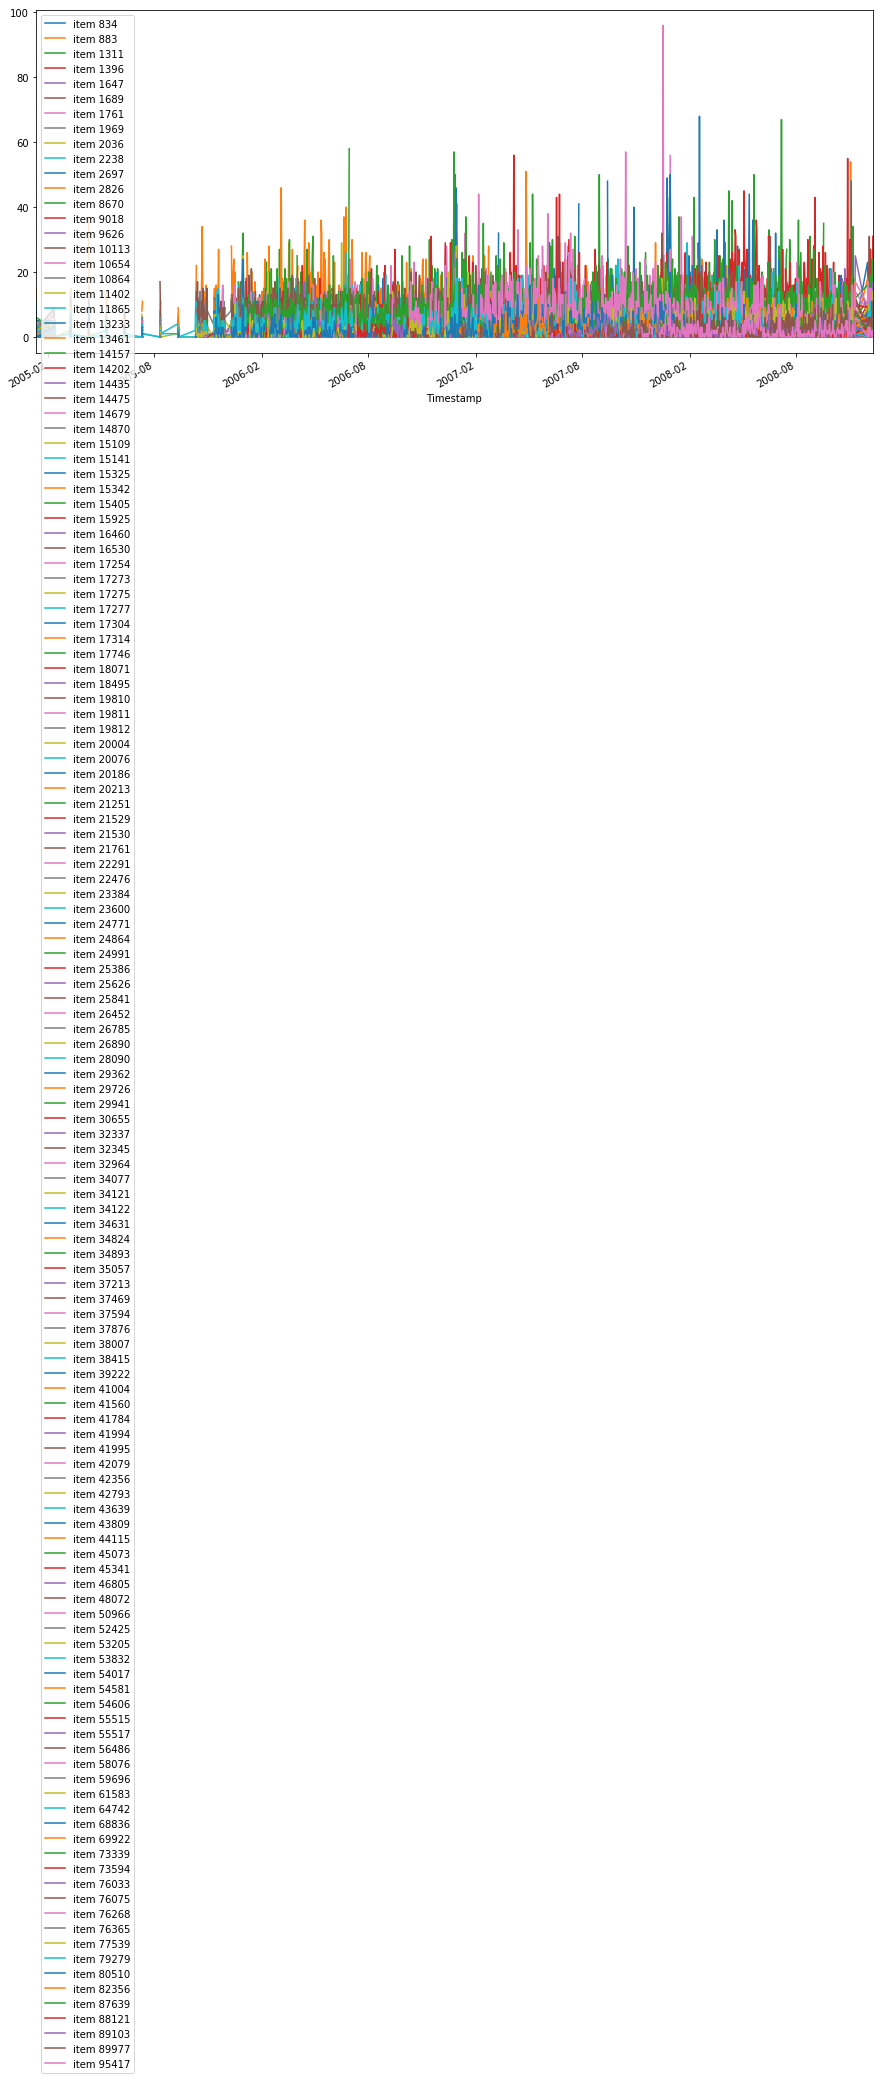

In [64]:
dep42.plot(figsize=(15, 7))

<h2 align="center">2. ARIMA Model real TS (70%) </h2>
You need to analyse a TS and build forecast with ARIMA model for it. 
Each student has its own TS: you can find id of yout TS that you need to forecast <a href="https://drive.google.com/open?id=1y5xgpgErIiJFYmXWB-eFYmQ6OUMocqP-VGpTIXLuzCw">here</a>. 

**I. Build ARIMA forecast yourself ** 

Also you can follow the next scheme:

 * 0) read data for TS under consideration and use the first 80% of all length of the TS as train TS.  
 * 1) plot the graph of the train TS, preprocess data (delete tail, make calendar transformation if needed)
 * 2) stabilize dispersion of the train TS through box-cox transformation if needed.
 * 3) if the transformed train TS is non-stationary make it stationary (remember the power of differencing $d$).
 * 4) plot ACF/PACF for  the transformed train TS in order to understand whether $AR(p)/MA(q)$ may be used.
 * 5) select set of candidate parameters for ARMA (for the train TS)
 * 6) train candidate ARIMA models (use $d$ from step 3), $p$, $q$ from step 5)), compare their AIC, choose the best model.
 * 7) check test for unbiasedness, stationarity and non-autocorrelation of the residuals of the best ARIMA model; if the tests fail you need to review your choice.
 * 8) build forecast for the initial TS (you need to transform it like in step 2)
 * 9) build forecast interval for the last 20% of the transformed initial TS. Calculate loss MACAPE of your forecast. Does the forecast look appropriate?

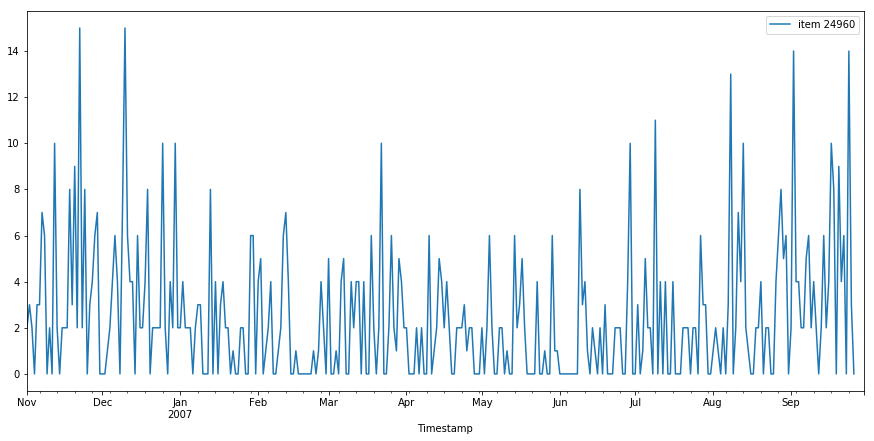

In [178]:
ts = dep6['item 24960'].to_frame()
ts.plot(figsize=(15, 7))

для стабилизации дисперсии используем Бокса-Кокса 

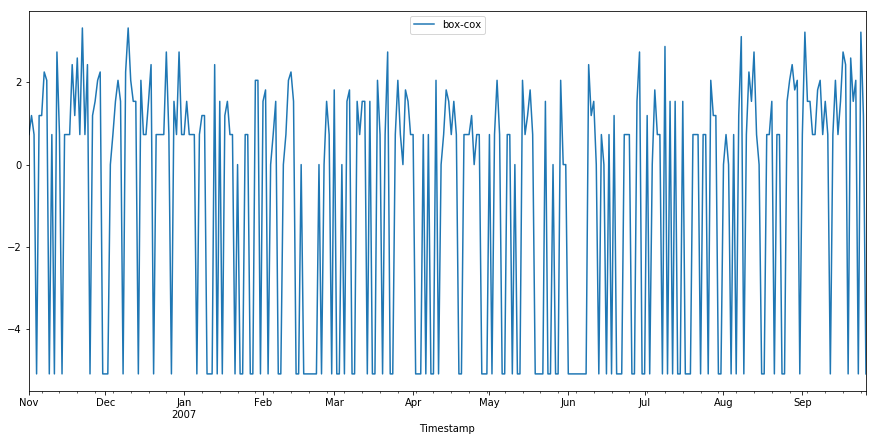

In [179]:
from copy import deepcopy
ts_boxcox = deepcopy(ts)
ts_boxcox = ts_boxcox.dropna()+0.0001
ts_boxcox['box-cox'], l = stats.boxcox(ts_boxcox)
ts_boxcox['box-cox'].to_frame().plot(figsize=(15, 7))

Теперь ряд можно считать стационарным

Построим графики ACF/PACF для определения параметров $p$ и $q$

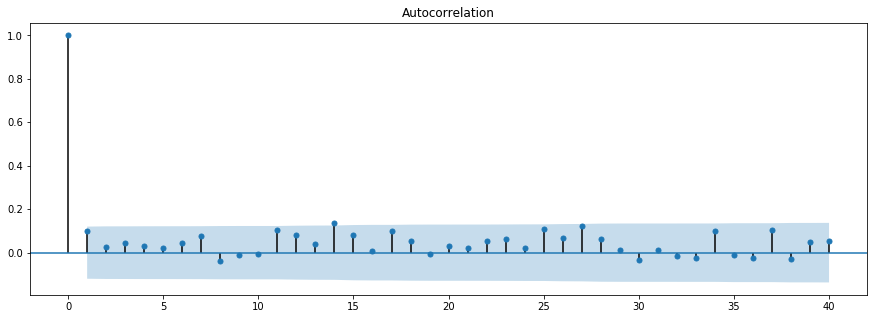

In [180]:
size = ts.shape[0]
train_size = int(size * 0.8)
test_size = size - train_size
train_ts_boxcox, test_ts_boxcox = ts_boxcox['box-cox'].head(train_size), ts_boxcox['box-cox'].tail(size - train_size)
fig = sm.graphics.tsa.plot_acf(train_ts_boxcox, lags=40)
fig.set_figheight(5)
fig.set_figwidth(15)

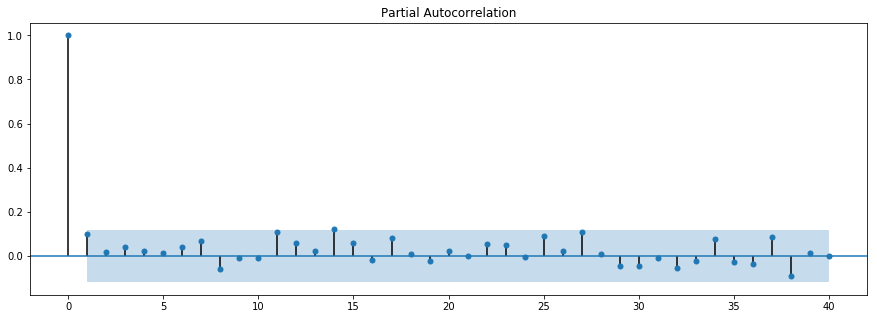

In [181]:
fig = sm.graphics.tsa.plot_pacf(train_ts_boxcox, lags=40)
fig.set_figheight(5)
fig.set_figwidth(15)

Глядя на последние статзначимые значения надо чтобы p,q~1

In [182]:
kpss_stat= stattools.kpss(np.array(train_ts_boxcox))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.806652, 
pvalue: 0.01 
maximal Lag: 16 
table distribution: {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}


In [183]:
p_arr = [1,2,3,4,5]
q_arr = [1,2,3,4,5]

In [184]:
best_p = 1
best_q = 1
best_score = sm.tsa.ARIMA(train_ts_boxcox, (1, 1, 1)).fit(disp=-1).aic
for p in p_arr:
    for q in q_arr:
        try:
            score = sm.tsa.ARIMA(train_ts_boxcox, (p, 1, q)).fit(disp=-1).aic
            if (score < best_score):
                best_score = score
                best_p = p
                best_q = q
        except:
            pass

In [185]:
best_p, best_q

(1, 2)

In [186]:
best_model = sm.tsa.ARIMA(train_ts_boxcox, (best_p, 1, best_q)).fit()

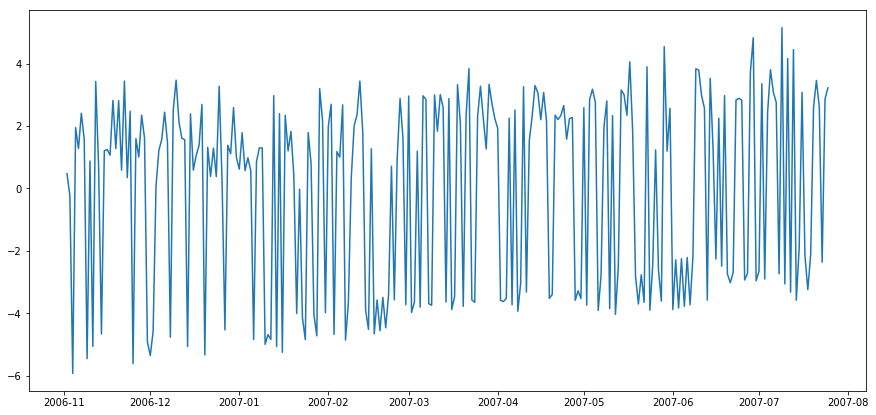

In [187]:
plt.figure(figsize=(15,7))
plt.plot(best_model.resid)

In [188]:
# Kwiatkowski–Phillips–Schmidt–Shin
residuals = best_model.resid
kpss_stat= stattools.kpss(residuals)
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.148621, 
pvalue: 0.10 
maximal Lag: 16 
table distribution: {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}


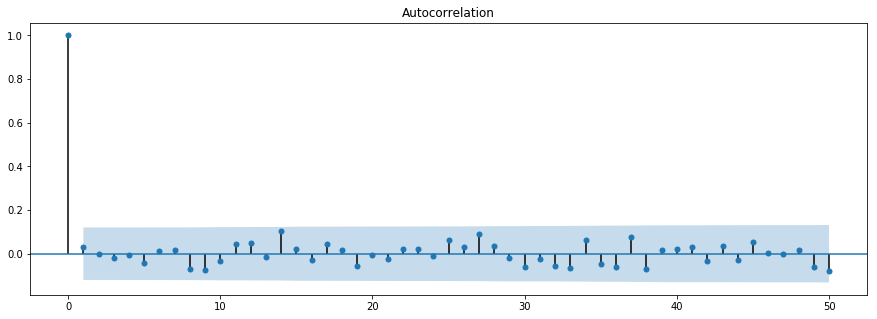

In [189]:
fig = sm.graphics.tsa.plot_acf(residuals, lags=50)
fig.set_figheight(5)
fig.set_figwidth(15)

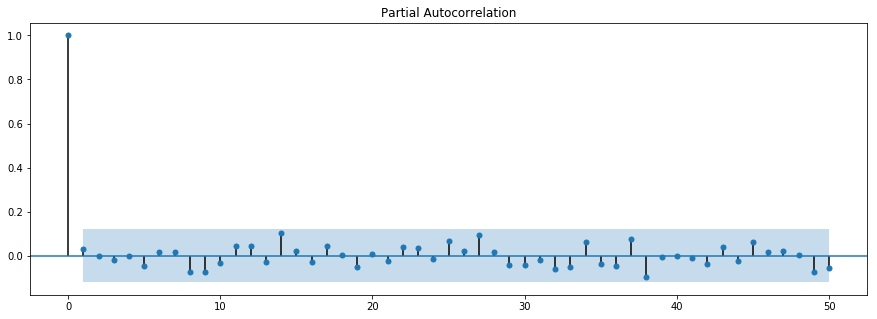

In [190]:
fig = sm.graphics.tsa.plot_pacf(residuals, lags=50)
fig.set_figheight(5)
fig.set_figwidth(15)

In [191]:
sm.stats.durbin_watson(residuals)

1.9356789222823818

In [192]:
stat = stats.wilcoxon(residuals)
print('Statistic: %f\npvalue: %.2f' %(stat[0], stat[1]))

Statistic: 15833.000000
pvalue: 0.13


Остатки неавтокореллированы, стационарны, с нулевым средним

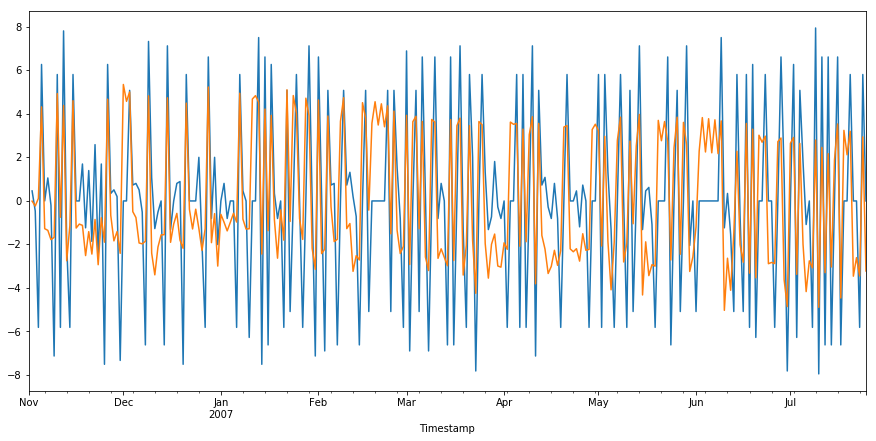

In [193]:
dif = train_ts_boxcox - train_ts_boxcox.shift()
dif.plot(figsize=(15,7))
best_model.fittedvalues.plot(figsize=(15,7))

In [194]:
best_p = 1
best_q = 1
d = 0
best_score = sm.tsa.ARIMA(train_ts_boxcox, (1, d, 1)).fit(disp=-1).aic
for p in p_arr:
    for q in q_arr:
        try:
            score = sm.tsa.ARIMA(train_ts_boxcox, (p, d, q)).fit(disp=-1).aic
            if (score < best_score):
                best_score = score
                best_p = p
                best_q = q
        except:
            pass

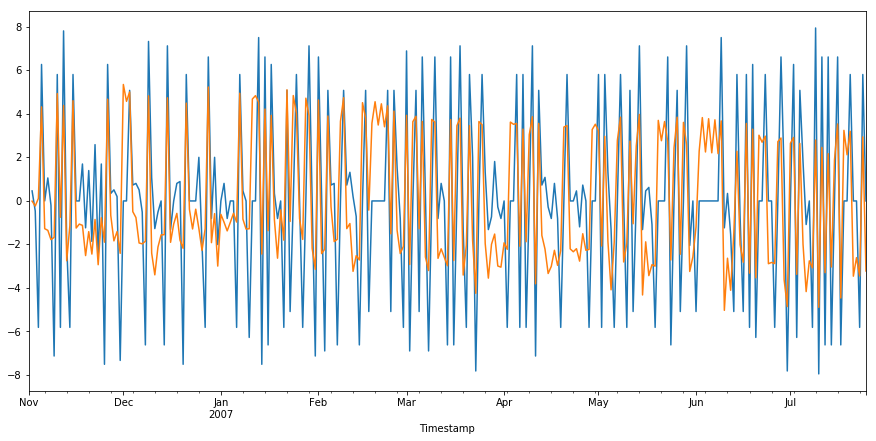

In [195]:
dif.plot(figsize=(15,7))
best_model.fittedvalues.plot(figsize=(15,7))

In [196]:
def macape(x,y):
    return np.mean(2*np.abs(x-y)/(x+y))

In [197]:
prediction = pd.Series(best_model.forecast(steps=len(test_ts_boxcox))[0], index=test_ts_boxcox.index)

In [198]:
print(macape(prediction.values, test_ts_boxcox.values))

-4.66451107037


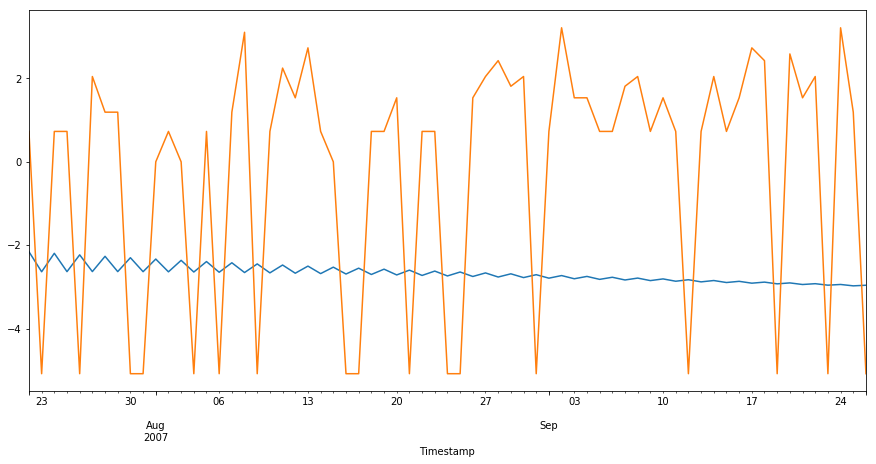

In [199]:
prediction.plot(figsize=(15,7))
test_ts_boxcox.plot(figsize=(15,7))

Видим, что зафитились неплохо на тестовой выборке, но плохо на тестовой выборке

**II. Find the best parameters of ARIMA automaticaly** 
* 0) read data for TS under consideration and use the first 80% of all length of the TS as train TS.  
* 1) plot the graph of the train TS, preprocess data (delete tail, make calendar transformation if needed)
* 2) stabilize dispersion of train TS through box-cox transformation if needed.
* 3) Run grid search for ARIMA parameters (use transformed train TS) according to AIC. Use at least 10 distinct values for $p,q,d$. How many time does it take?
* 4) Build forecast for the initial TS with best ARIMA model selected automaticaly at step 2 (you need to transform it like in step 2).
* 5) Build forecast interval for the last 20% of transformed TS. Calculate loss MACAPE of your forecast. Does the forecast look appropriate?

In [200]:
p_arr = range(10)
d_arr = range(10)
q_arr = range(10)

In [201]:
best_p = 0
best_q = 0
best_d = 0
best_score = sm.tsa.ARIMA(train_ts_boxcox, (0,0,0)).fit(disp=-1).aic
for p in p_arr:
    for q in q_arr:
        for d in d_arr:
            try:
                score = sm.tsa.ARIMA(train_ts_boxcox, (p, d, q)).fit(disp=-1).aic
                if (score < best_score):
                    best_score = score
                    best_p = p
                    best_q = q
                    best_d = d
            except:
                pass

In [202]:
best_model = ARIMA(train_ts_boxcox, (best_p,best_d,best_q)).fit()

In [170]:
best_p,best_d,best_q

(1, 1, 2)

In [171]:
fitted = pd.Series(best_model.fittedvalues)

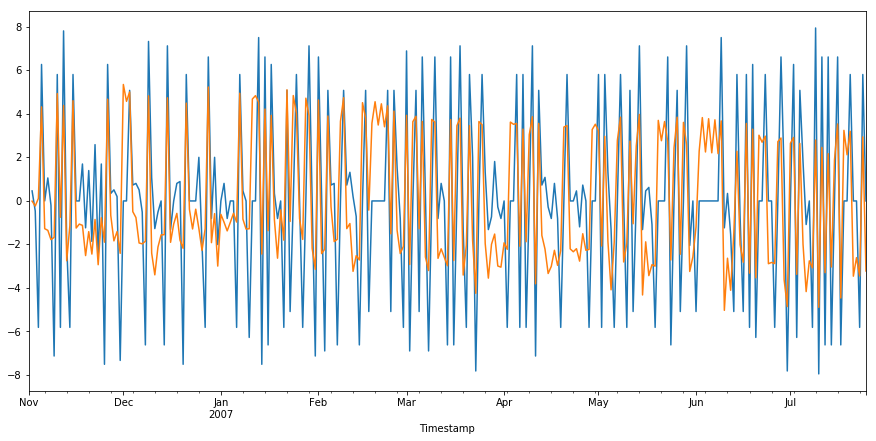

In [173]:
dif = train_ts_boxcox - train_ts_boxcox.shift()
dif.plot(figsize=(15,7))
fitted.plot(figsize=(15,7))

In [174]:
prediction = pd.Series(best_model.forecast(steps=len(test_ts_boxcox))[0], index=test_ts_boxcox.index)

In [175]:
print(macape(prediction.values, test_ts_boxcox.values))

-4.66451107037


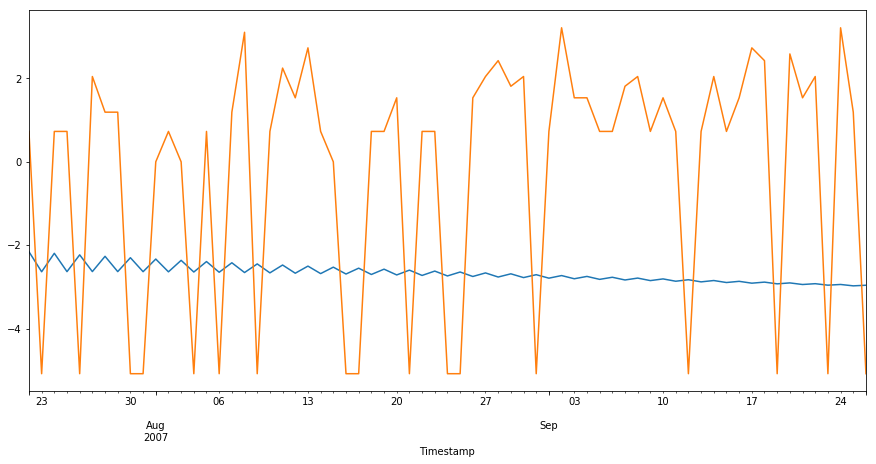

In [177]:
prediction.plot(figsize=(15,7))
test_ts_boxcox.plot(figsize=(15,7))

Такой же результат